In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import numpy.random as rand
from itertools import islice
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)
import sklearn.datasets as datasets
import sklearn.model_selection as cv
import sklearn.metrics as metrics
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (9, 7)
# from IPython.display import HTML
from DataCleaning import data_cleaning

In [179]:
X, y, columns = data_cleaning('data/churn_train.csv')

In [3]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y)

In [4]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [5]:
def model_scores(X, y, estimator, p=False, train=False):
    if train:
        scores = cv.cross_validate(estimator, X, y, scoring=['accuracy', 'precision', 'recall', 'neg_log_loss'], cv=5)
        acc = np.mean(scores['test_accuracy'])
        precision = np.mean(scores['test_precision'])
        recall = np.mean(scores['test_recall'])
        log_loss = -np.mean(scores['test_neg_log_loss'])
    else:
        y_hat = estimator.predict(X)
        acc = metrics.accuracy_score(y, y_hat)
        precision = metrics.precision_score(y, y_hat)
        recall = metrics.recall_score(y, y_hat)
        log_loss = metrics.log_loss(y, estimator.predict_proba(X))
    if p:
        print ("Accuracy: {0:2.3} | Precision: {1:2.3} | Recall: {2:2.3} | Log_loss: {3:2.3}".format(
                                                                    acc, precision, recall, log_loss))                                                           
    else:
        return acc, precision, recall, log_loss

In [6]:
print ('Train_Data')
model_scores(X_train, y_train, rfc, p=True, train=False)

Train_Data
Accuracy: 0.728 | Precision: 0.754 | Recall: 0.413 | Log_loss: 0.558


In [7]:
print ('Test_Data')
model_scores(X_test, y_test, rfc, p=True)

Test_Data
Accuracy: 0.73 | Precision: 0.75 | Recall: 0.414 | Log_loss: 0.558


In [8]:
1 - y.mean()

0.6242

null
churn = .625
retain = .375

In [10]:
metrics.confusion_matrix(y_test, rfc.predict(X_test))

array([[5751,  516],
       [2189, 1544]])

In [135]:
1608 / (2182+1608)

0.42427440633245384

In [11]:
from sklearn.linear_model import LogisticRegression

In [217]:
metrics.confusion_matrix(y_test, rf_prediction)

array([[5417,  793],
       [1290, 2500]])

In [142]:
metrics.accuracy_score(y_test, LR.predict(X_test))

0.7197

In [146]:
null_y = np.ones(len(y_test*y_test.mean()))

In [147]:
metrics.confusion_matrix(y_test, null_y)

array([[   0, 6210],
       [   0, 3790]])

In [160]:
'''logistic_regression_grid = {'fit_intercept': [True, False],
                            'solver': ['lbfgs', 'saga'],
                            'random_state': [2]}

lr_gridsearch = cv.GridSearchCV(LogisticRegression(),
                                logistic_regression_grid,
                                n_jobs=-1,
                                verbose=True,
                                scoring='neg_log_loss',
                                cv=5)
lr_gridsearch.fit(X_train, y_train)

print("best parameters:        ", lr_gridsearch.best_params_)

lr_best_estimator = lr_gridsearch.best_estimator_
print('best estimator:         ', best_estimator)

lr_best_prediction = best_estimator.predict(X_test)
print('Log_loss of best estimator:  ', metrics.recall_score(y_test, best_prediction))'''

In [183]:
random_forest_grid = {'criterion':['entropy'],
                      'max_depth': [None],
                      'max_features': ['sqrt'],
                      'min_samples_split': [2],
                      'min_samples_leaf': [10],
                      'bootstrap': [True],
                      'n_estimators': [150, 200, 300],
                      'random_state': [2]}

rf_gridsearch = cv.GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss',
                             cv=5)
rf_gridsearch.fit(X_train, y_train)
print("best parameters:        ", rf_gridsearch.best_params_)

rf_best_estimator = rf_gridsearch.best_estimator_
print('best estimator:         ', rf_best_estimator)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   13.0s finished


best parameters:         {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 2}
best estimator:          RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


In [186]:
rf_best_prediction = rf_best_estimator.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, rf_best_prediction))
print('Precision of best: ', metrics.precision_score(y_test, rf_best_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, rf_best_prediction))

Accuracy  of best:  0.791
Precision of best:  0.7586731588557517
Recall    of best:  0.6577836411609499


In [191]:
gradient_boosted_grid = {'loss':['exponential', 'deviance'],
                         'max_depth': [None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5],
                         'n_estimators': [200],
                         'random_state': [2]}

gbr_gridsearch = cv.GridSearchCV(GradientBoostingClassifier(),
                             gradient_boosted_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss',
                             cv=5)
gbr_gridsearch.fit(X_train, y_train)

print("best parameters:        ", gbr_gridsearch.best_params_)

In [198]:
gbr_best_estimator = gbr_gridsearch.best_estimator_
print('best estimator:         ', gbr_best_estimator)

best estimator:          GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=None,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [192]:
gbr_best_prediction = gbr_best_estimator.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, gbr_best_prediction))
print('Precision of best: ', metrics.precision_score(y_test, gbr_best_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, gbr_best_prediction))

Accuracy  of best:  0.7556
Precision of best:  0.6795624332977588
Recall    of best:  0.6720316622691292


In [204]:
gbr =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=None,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gbr.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=None,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [212]:
gbr_prediction = gbr.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, gbr_prediction))
print('Precision of best: ', metrics.precision_score(y_test, gbr_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, gbr_prediction))

Accuracy  of best:  0.756
Precision of best:  0.6785714285714286
Recall    of best:  0.6767810026385225


In [224]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=2, verbose=0,
                       warm_start=False)

rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
print('Accuracy  of best: ', metrics.accuracy_score(y_test, rf_prediction))
print('Precision of best: ', metrics.precision_score(y_test, rf_prediction))
print('Recall    of best: ', metrics.recall_score(y_test, rf_prediction))


Accuracy  of best:  0.7913
Precision of best:  0.7587359465208143
Recall    of best:  0.6588390501319261


In [187]:
importances = np.empty((300, len(columns)))
for i, tree in enumerate(rf_best_estimator.estimators_):
    importances[i, :] = tree.feature_importances_

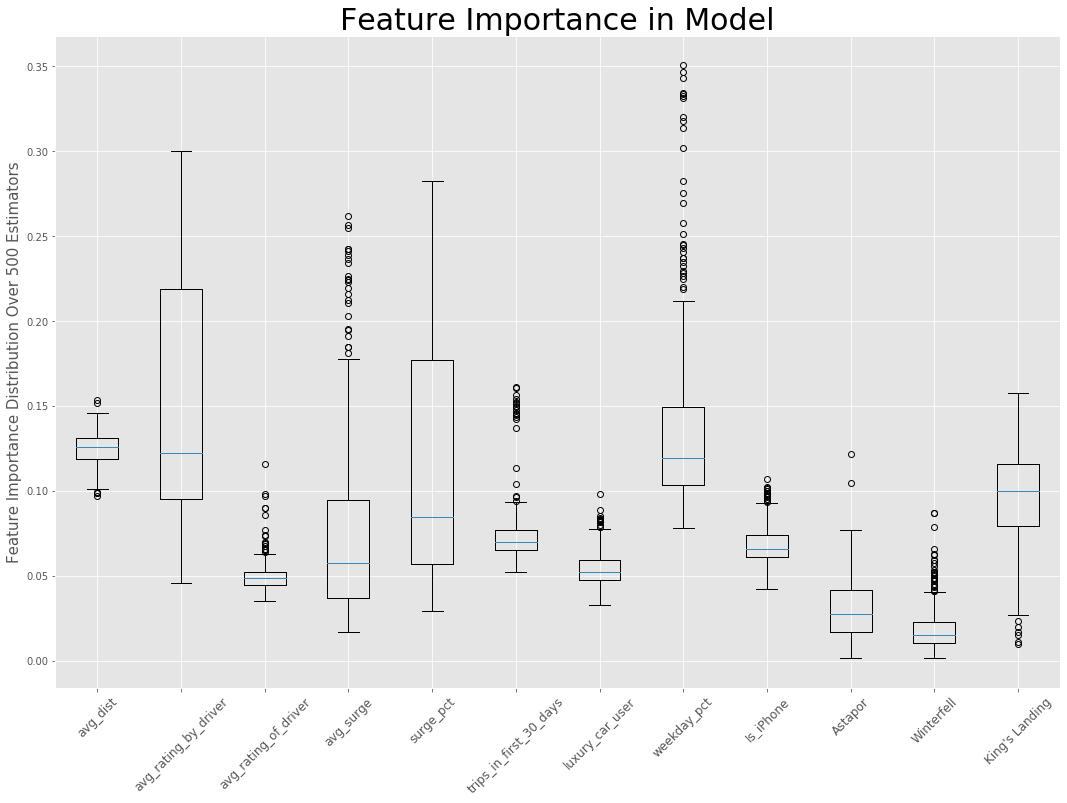

In [241]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.boxplot(importances, labels=columns)
ax.set_ylabel('Feature Importance Distribution Over 500 Estimators', fontsize=15)
ax.set_xticklabels(labels=columns, rotation=45, fontsize=12)
ax.set_title('Feature Importance in Model', fontsize=30)
fig.savefig('FeatureImportance.png');

In [210]:
LR = LogisticRegression(solver='lbfgs', max_iter=10000)
LR.fit(X, y)
LR.coef_

array([[-3.60352251e-02, -1.53326108e-01, -1.31931776e-01,
        -1.90516584e-01,  3.88228491e-03,  1.19982635e-01,
         8.72422433e-01, -2.59695823e-04,  1.09128027e+00,
        -7.65083107e-01, -2.53607519e-01,  9.67807954e-01]])

In [211]:
for coef, col in zip(LR.coef_[0], columns):
    print (col, coef)

avg_dist -0.036035225112613235
avg_rating_by_driver -0.15332610846441097
avg_rating_of_driver -0.131931776345065
avg_surge -0.19051658403066463
surge_pct 0.003882284911200696
trips_in_first_30_days 0.11998263474404258
luxury_car_user 0.8724224331712732
weekday_pct -0.00025969582311809815
Is_iPhone 1.0912802696788129
Astapor -0.7650831068426013
Winterfell -0.2536075187733669
King's Landing 0.9678079543608353


In [215]:
from roc import plot_roc

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
plot_roc(X, y, rf, 'ROC', ax)
plt.show()
fig.tight_layout()
fig.savefig('Model_ROC.png');

In [185]:
X_test, y_test = data_cleaning('data/churn_test.csv')

FileNotFoundError: [Errno 2] File b'data/churn_test.csv' does not exist: b'data/churn_test.csv'

In [ ]:
best_model.fit(X, y)
best_model.predict(y_test)